In [16]:
import numpy as np
import sympy
import matplotlib.pylab as plt
%matplotlib inline

**Description of lag calculation from Siegel et al. 2015 (JCBFM)**

$$C_i(\tau) = (1/n_\tau)\sum \left[ \frac{g(t) \cdot s_i(t + \tau)}{\sigma_{s_i}\sigma_g}  \right]$$

* ***g*** is the gray matter signal
* ***s<sub>i</sub>*** is the signal in voxel ***i***
* ***σ<sub>s<sub>i</sub></sub>*** and  ***σ<sub>g</sub>*** are the standard deviations of the two signals

The summation runs over frames indexed by ***t***, and ***n<sub>τ</sub>***  is the number of frames included after a shift of ***τ***.

To determine the shift that maximizes the cross-correlation function at a temporal resolution finer than 1 TR, the lag (***τ***) corresponding to the maximum of ***C<sub>i</sub> (τ)*** is identified. ***C<sub>i</sub> (τ)*** at this lag, as well as one step forward and backward, is fit with a parabolic function and the peak value, ***C<sub>i</sub>  (τ<sup>m</sup>)*** and corresponding temporal shift ***(τ<sup>m</sup>)*** is computed. Positive and negative values of  ***τ<sup>m</sup>*** correspond, respectively, to a lag or lead relative to the mean gray matter signal.

In [89]:
def get_numerator(signal_a, signal_b, lag):
    if lag == 0:
        numerator = np.multiply(signal_a, signal_b)
    if lag > 0:
        numerator = np.multiply(signal_a[lag:], signal_b[0:-lag])
    if lag < 0:
        numerator = np.multiply(signal_b[-lag:], signal_a[0:lag])
    return numerator

In [90]:
def get_denominator(signal_a, signal_b):
    return np.std(signal_a) * np.std(signal_b)

In [248]:
def xcorr(signal_a, signal_b, lags):
    corr_vals = []
    for i in lags:
        corr = np.true_divide(1., len(signal_a)-i) * np.sum(np.true_divide(get_numerator(signal_a, signal_b, i),
              get_denominator(signal_a, signal_b)))
        corr_vals.append(corr)
    return corr_vals

Now, let's generate some test data.

First, two aperiodic time-series, with a lag difference of 3 frames.

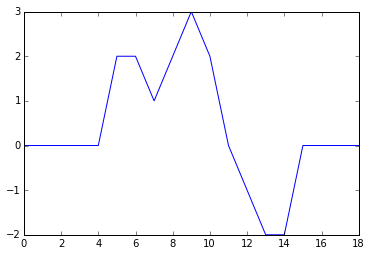

In [245]:
signal_a = [0, 0, 0, 0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0]
plt.plot(signal_a)

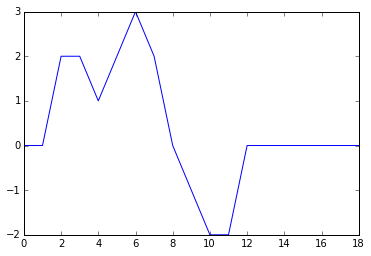

In [246]:
signal_b = [0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0, 0, 0, 0]
plt.plot(signal_b)

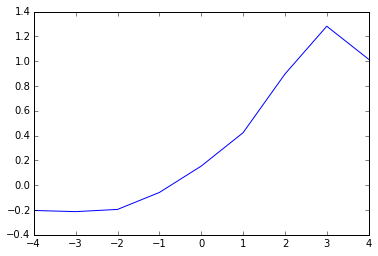

In [249]:
lags = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
plt.plot(lags, xcorr(signal_a, signal_b, lags))

In [143]:
np.argmax(xcorr)

6

In [138]:
from __future__ import division
from numpy import polyfit, arange

def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
   
    f is a vector and x is an index for that vector.
   
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
   
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
   
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
   
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
   
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)


In [144]:
parabolic(xcorr, 6)

(6.0916703393565452, 1.2224856769556869)

In [159]:
import statsmodels as sm

In [177]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arima_process.arma_generate_sample(ar, ma, 250)

In [207]:
z = sm.tsa.arima_process.arma_generate_sample(ar, ma, 250)

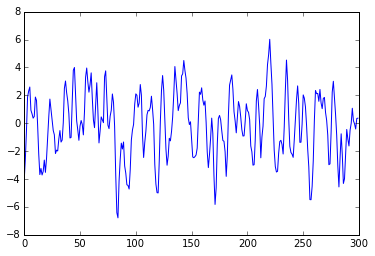

In [214]:
signal_a = np.append(z[-50:], y)
plt.plot(signal_a)

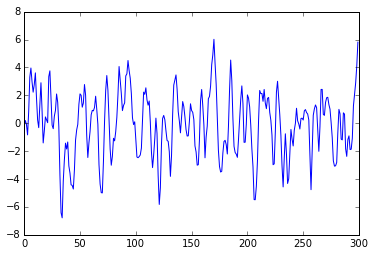

In [232]:
signal_b = np.append(y, z[0:50])
plt.plot(signal_b)

In [239]:
np.arange(0, 65, 8)

array([ 0,  8, 16, 24, 32, 40, 48, 56, 64])

In [240]:
lags = [-64, -56, -48, -40, -32, -24, -16, -8, 0, 8, 16, 24, 32, 40, 48, 56, 64]

In [241]:
xcorr = []
for i in lags:
    corr = np.true_divide(1., len(signal_a)-i) * np.sum(np.true_divide(get_numerator(signal_a, signal_b, i),
              get_denominator(signal_a, signal_b)))
    xcorr.append(corr)

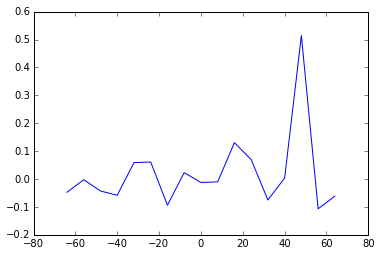

In [242]:
plt.plot(lags, xcorr)

In [243]:
print(np.max(xcorr), np.argmax(xcorr), lags[np.argmax(xcorr)])

(0.51414852754317775, 14, 48)


In [244]:
parabolic(xcorr, 14)

(13.951283646717062, 0.51549174023347044)